In [1]:
%load_ext autoreload
%autoreload 2

## Setup Dask

In [2]:
import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

dask.config.set(**{'array.slicing.split_large_chunks': False})

portdash = 10062

cluster = SLURMCluster(
    queue="batch",
    cores=8,
    processes=1,
    account="gfdl_o",
    memory="48GB",
    walltime="08:00:00",
    local_directory="$TMPDIR",
    death_timeout=240,
    scheduler_options={"dashboard_address":f":{portdash}"},
    job_extra_directives=["--exclude=pp[008-010],pp[013-075]"],
    job_name="mhw-metrics"
)

client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.208.147.197:10062/status,
Dashboard: http://140.208.147.197:10062/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.208.147.197:37207,Workers: 0
Dashboard: http://140.208.147.197:10062/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.scale(jobs=30)

## Import Modules

In [6]:
import xarray as xr
import numpy as np
import dask.array as da

import util
import events
import mhwmetrics
import annualcycle

In [ ]:
%%time
ds = xr.open_zarr("/xtmp/Xinru.Li/work/cm4_thetao_0151_0250_fast_detrend", use_cftime=True)

In [ ]:
%%time
def process_chunk(temp_chunk):
    temp_chunk = temp_chunk.load()
    mean, thresh = events.threshold_and_climo(temp_chunk)
    exceedences, thresh_tiled = events.calculate_execeedences(temp_chunk, thresh)
    event_index, num_events = events.tag_events(exceedences)
    dsmetrics = mhwmetrics.calc_metrics(event_index, event_index, thresh_tiled)

    try:
        assert "clim_freq" in dsmetrics.variables.keys()
    except Exception as exc:
        print(temp_chunk)
        print(dsmetrics)
        raise exc
    return dsmetrics

#result = process_chunk(temp_chunk)

In [ ]:
# Suppose your final output domain has shape (16, 1080, 1440)
z_size, y_size, x_size = (16, 1080, 1440)

# Choose chunk sizes for dask
z_chunks, y_chunks, x_chunks = (16, 20, 20)

# Build a dask array that spans the full domain
arr_shape = (z_size, y_size, x_size)
arr_chunks = (z_chunks, y_chunks, x_chunks)
dask_data  = da.zeros(arr_shape, chunks=arr_chunks, dtype='float32')

# Create a template with that full shape but chunked as you prefer
template = xr.Dataset(
    {
       'clim_freq':   (('z2000_l','yh','xh'), dask_data),
       'clim_dur':    (('z2000_l','yh','xh'), dask_data),
       'clim_Im':     (('z2000_l','yh','xh'), dask_data),
       'clim_Atot':   (('z2000_l','yh','xh'), dask_data),
       'clim_HSpeak': (('z2000_l','yh','xh'), dask_data),
    },
    coords={
        'z2000_l': ds.z2000_l,  # length 16
        'yh':       ds.yh,      # length 1080
        'xh':       ds.xh,      # length 1440
    }
)

In [ ]:
%%time
result = xr.map_blocks(
    process_chunk,            # your function
    ds.thetao,               # the dataset to split into blocks
    template=template,       # structure of each block's output
)

In [ ]:
%%time
result

In [ ]:
%%time
result = result.compute()

In [ ]:
result.to_netcdf("results.nc")

In [7]:
ds = xr.open_dataset("results.nc")

In [8]:
ds

<xarray.Dataset>
Dimensions:      (z2000_l: 16, yh: 1080, xh: 1440)
Coordinates:
  * z2000_l      (z2000_l) float64 2.5 10.0 20.0 32.5 ... 500.0 600.0 700.0
  * yh           (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xh           (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
Data variables:
    clim_freq    (z2000_l, yh, xh) float32 ...
    clim_dur     (z2000_l, yh, xh) float32 ...
    clim_Im      (z2000_l, yh, xh) float32 ...
    clim_Atot    (z2000_l, yh, xh) float32 ...
    clim_HSpeak  (z2000_l, yh, xh) float32 ...

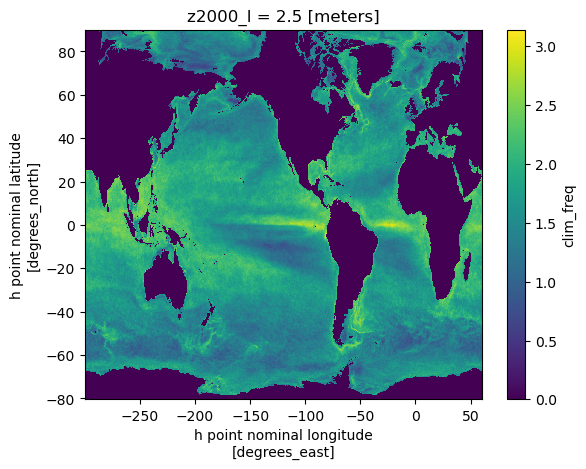

In [9]:
ds.clim_freq[0].plot()